In [1]:
# get tuned alg results for each split separately

import pandas as pd
import numpy as np

metadataset_df = pd.read_csv("./results/tuned_fold_results.csv")


In [636]:
# read cleaned metafeatures file
keep_metafeatures_df = pd.read_csv("./results/cleaned_metafeatures.csv", index_col=0)

all_feature_cols = [c for c in keep_metafeatures_df.columns if c.startswith("f__")]

for f in all_feature_cols:
    if (keep_metafeatures_df.loc[:, f] > 0).all():
        keep_metafeatures_df.loc[:, f"{f}_LOG"] = np.log(keep_metafeatures_df.loc[:, f])

# drop cols that are all NaN

# keep_metafeatures_df.loc[keep_metafeatures_df.isna().sum() > 0, :]
na_feats = keep_metafeatures_df.isna().sum() == len(keep_metafeatures_df)
na_feat_names = list(na_feats[na_feats].index)
print(f"dropping cols with only NA: {na_feat_names}")
keep_metafeatures_df.drop(columns=na_feat_names, inplace=True)

# replace inf with something else
keep_metafeatures_df.replace([np.inf, -np.inf], 0.0, inplace=True)

all_feature_cols = [c for c in keep_metafeatures_df.columns if c.startswith("f__") and ~c.endswith("LOG")]
all_feature_cols_with_log = [c for c in keep_metafeatures_df.columns if c.startswith("f__")]

# only keep some features
# all_feature_cols = [c for c in keep_metafeatures_df.columns if c.startswith("f__pymfe.info") or c.startswith("f__pymfe.complexity") or c.startswith("f__pymfe.statistical") or c.startswith("f__pymfe.clustering") or c.startswith("f__pymfe.general")]


def simplify(x):
    return x.replace("statistical", "stat").replace("model-based", "model").replace("landmarking", "landmark").replace("skewness", "skew")

nice_feature_names = [simplify(f[len("f__pymfe."):]) for f in all_feature_cols]

/var/folders/mv/xx16lc8s74g35q1kd_93l7_w0000gn/T/ipykernel_74742/1393479155.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/mv/xx16lc8s74g35q1kd_93l7_w0000gn/T/ipykernel_74742/1393479155.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/var/folders/mv/xx16lc8s74g35q1kd_93l7_w0000gn/T/ipykernel_74742/1393479155.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(

dropping cols with only NA: ['f__pymfe.statistical.iq_range', 'f__pymfe.statistical.t_mean']


## merge performance dataset with metafeatures

In [637]:
metric_col = "normalized_Accuracy__test"
failure_percentile = 0.2
df = metadataset_df.merge(keep_metafeatures_df, left_on="dataset_fold_id", right_on="dataset_name", how="left")

# drop all nans 
df.drop(index=df.loc[df[metric_col].isna(), :].index, inplace=True)


min_num_leaves = 10
max_depth = 2

import numpy as np
q = 0.1
figsize=(7, 5)
alg_quantiles = df.groupby("alg_name")[metric_col].apply(lambda x: np.quantile(x, q))

from sklearn import metrics

In [638]:
alg_quantiles

alg_name
CatBoost              0.538462
DANet                 0.333333
DecisionTree          0.000000
DeepFM                0.000000
KNN                   0.000000
LightGBM              0.428571
LinearModel           0.000000
MLP                   0.186583
NAM                   0.000000
NODE                  0.333333
RandomForest          0.416667
SAINT                 0.259091
STG                   0.000000
SVM                   0.308753
TabNet                0.000000
TabPFNModel           0.428571
TabTransformer        0.000000
VIME                  0.000000
XGBoost               0.500000
rtdl_FTTransformer    0.285714
rtdl_MLP              0.166667
rtdl_ResNet           0.384058
Name: normalized_Accuracy__test, dtype: float64

In [639]:
# set the failure threshold equal for all algs

# alg_quantiles[:] = 0.5

### Find failure modes for each alg

In [640]:
import scipy

def corr(x, y):  
    c = scipy.stats.pearsonr(x, y)
    return c.statistic, c.pvalue

In [641]:
# from xgboost import XGBClassifier

# def get_importances(x, y, split_category, n_estimators=100):

#     imp_list = []
#     category_list = list(set(split_category))
#     for c in category_list:
            
#         # create train-test splits based on dataset 
#         test_ind = split_category == c
#         train_ind = ~test_ind

#         x_train = x[train_ind, :]
#         x_test = x[test_ind, :]

#         y_train = y[train_ind].astype(int)
#         y_test = y[test_ind].astype(int)

#         # fit a tree with limited max depth
#         clf = XGBClassifier(n_estimators=150, objective='binary:logistic', use_label_encoder=False).fit(x_train, y_train)

#         imp_list.append(clf.feature_importances_)

#     # find the most importan features
#     feature_importance_mean = np.mean(imp_list, axis=0)

#     return feature_importance_mean
    
#     # sorted_inds = (-feature_importance_mean).argsort()
#     # for j in range(10):
#     #     print(f"{j + 1}: {feature_cols[sorted_inds[j]]} ({feature_importance_mean[sorted_inds[j]]})")

In [642]:

# x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
# y = df_alg["failure"]

# imp = get_importances(x, y, df_alg["dataset_name_x"].values, n_estimators=50)

## CatBoost

In [710]:
alg = "CatBoost"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.54
failures: 163
successes: 1465


In [711]:
from sklearn import tree
from xgboost import XGBClassifier

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train xgb for feature selection
# clf = XGBClassifier(n_estimators=50, objective='binary:logistic', use_label_encoder=False).fit(x, y)

# # fit using 50 most important features
# keep_inds = (-clf.feature_importances_).argsort()[:20]
# keep_feats = [all_feature_cols[i] for i in keep_inds]
# keep_feats_nice = [nice_feature_names[i] for i in keep_inds]

# x_keep = df_alg[keep_feats].values.clip(-1e10, 1e10)

# # train a single tree of max-depth 5 to visualize
# clf_display_keep = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves).fit(x_keep, y)
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves).fit(x, y)

In [712]:
clf_display.classes_

array([0, 1])

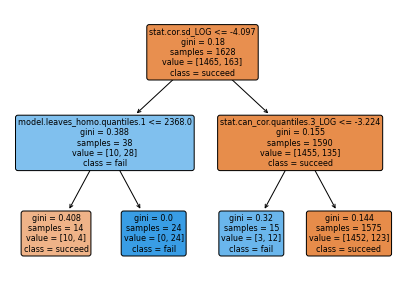

accuracy of this classifier: 0.9201474201474201
base rate: 0.8998771498771498


In [713]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")

most correlated features with norm. accuracy
f__pymfe.statistical.cov.min : -0.28853424446299275 (p=1.39e-32)
f__pymfe.statistical.cov.quantiles.1 : -0.28248870271851706 (p=3.01e-31)
f__pymfe.statistical.eigenvalues.min : -0.27345874483005944 (p=2.59e-29)
f__pymfe.statistical.cov.histogram.3 : -0.22924998937997584 (p=7.40e-21)
f__pymfe.statistical.skewness.sd_LOG : 0.2213951911802997 (p=1.59e-19)
f__pymfe.landmarking.random_node.min.relative_LOG : -0.21240691110182802 (p=4.61e-18)
f__pymfe.statistical.cor.min : -0.20762584854327557 (p=2.60e-17)
f__pymfe.landmarking.random_node.min.relative : -0.2053895096684153 (p=5.75e-17)
f__pymfe.model-based.nodes_per_inst_LOG : -0.198435238705442 (p=6.43e-16)
f__pymfe.statistical.can_cor.max_LOG : 0.1972070194690522 (p=9.76e-16)
f__pymfe.statistical.max.min : -0.19046685662774887 (p=9.17e-15)
f__pymfe.statistical.can_cor.mean_LOG : 0.19024692508975607 (p=9.86e-15)
f__pymfe.statistical.kurtosis.sd_LOG : 0.18694419333461276 (p=2.87e-14)
f__pymfe.stat

Text(0, 0.5, 'normalized_Accuracy__test')

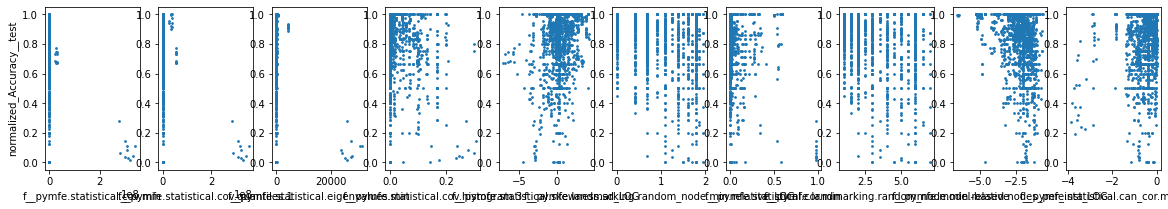

In [716]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


## LightGBM

In [757]:
alg = "LightGBM"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.43
failures: 164
successes: 1471


In [758]:
from sklearn import tree
from xgboost import XGBClassifier

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train xgb for feature selection
# clf = XGBClassifier(n_estimators=50, objective='binary:logistic', use_label_encoder=False).fit(x, y)

# # fit using 50 most important features
# keep_inds = (-clf.feature_importances_).argsort()[:20]
# keep_feats = [all_feature_cols[i] for i in keep_inds]
# keep_feats_nice = [nice_feature_names[i] for i in keep_inds]

# x_keep = df_alg[keep_feats].values.clip(-1e10, 1e10)

# # train a single tree of max-depth 5 to visualize
# clf_display_keep = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves).fit(x_keep, y)
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves).fit(x, y)

In [759]:
clf_display.classes_

array([0, 1])

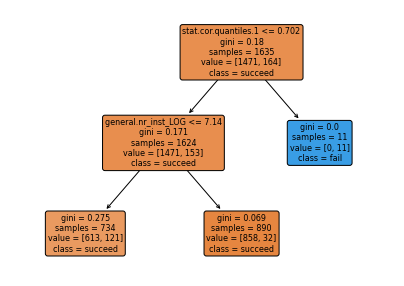

accuracy of this classifier: 0.9064220183486239
base rate: 0.8996941896024465


In [760]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.general.nr_inst_LOG : 0.4105734489124624 (p=1.65e-67)
f__pymfe.model-based.leaves_corrob.min_LOG : -0.3126688822389009 (p=2.08e-38)
f__pymfe.model-based.leaves_corrob.median_LOG : -0.3116425614531548 (p=3.72e-38)
f__pymfe.model-based.leaves_corrob.quantiles.1_LOG : -0.31152189553921056 (p=3.99e-38)
f__pymfe.model-based.leaves_corrob.quantiles.3_LOG : -0.2921676563577523 (p=1.54e-33)
f__pymfe.model-based.leaves_corrob.iq_range_LOG : -0.29016695717639873 (p=4.38e-33)
f__pymfe.landmarking.one_nn.range : -0.2900109419975955 (p=4.75e-33)
f__pymfe.landmarking.one_nn.sd : -0.2888925339854711 (p=8.49e-33)
f__pymfe.general.inst_to_attr_LOG : 0.2699834052032722 (p=1.05e-28)
f__pymfe.general.attr_to_inst_LOG : -0.269983405203272 (p=1.05e-28)
f__pymfe.landmarking.one_nn.iq_range : -0.2694175294689096 (p=1.38e-28)
f__pymfe.landmarking.naive_bayes.sd : -0.2591060248523659 (p=1.72e-26)
f__pymfe.model-based.tree_depth.histogram.9_LOG : -0.257985812

Text(0, 0.5, 'normalized_Accuracy__test')

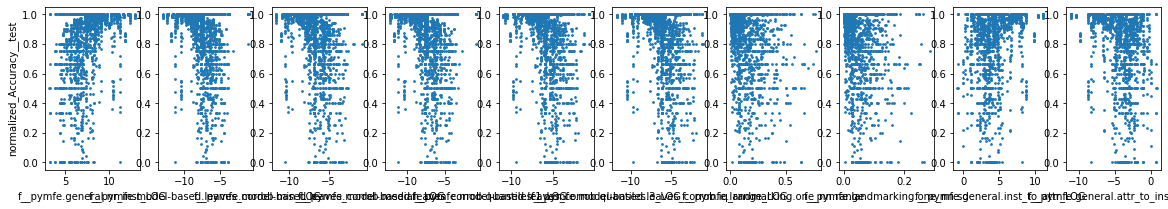

In [761]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


### XGBoost

In [717]:
alg = "XGBoost"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.50
failures: 181
successes: 1524


In [718]:
from sklearn import tree

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=10).fit(x, y)

In [719]:
clf_display.classes_

array([0, 1])

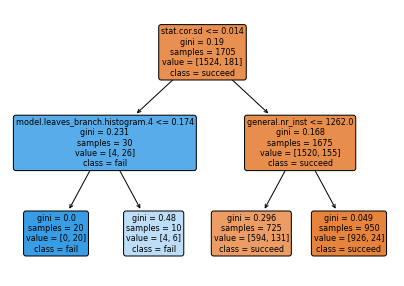

accuracy of this classifier: 0.9067448680351906
base rate: 0.893841642228739


In [720]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.general.nr_inst_LOG : 0.3553166132441435 (p=6.69e-52)
f__pymfe.model-based.leaves_corrob.min_LOG : -0.2779985469032322 (p=1.24e-31)
f__pymfe.model-based.leaves_corrob.quantiles.1_LOG : -0.27315460807582476 (p=1.48e-30)
f__pymfe.model-based.leaves_corrob.median_LOG : -0.26952450003755235 (p=9.18e-30)
f__pymfe.model-based.leaves_corrob.quantiles.3_LOG : -0.25401624161557745 (p=1.63e-26)
f__pymfe.model-based.leaves_corrob.iq_range_LOG : -0.2521794621898785 (p=3.82e-26)
f__pymfe.model-based.leaves_corrob.histogram.0 : 0.22958140830893706 (p=7.89e-22)
f__pymfe.model-based.tree_depth.histogram.9_LOG : -0.22064358566024841 (p=3.03e-20)
f__pymfe.statistical.cov.min : -0.21978723344259354 (p=4.26e-20)
f__pymfe.landmarking.one_nn.range : -0.21887909522748428 (p=6.11e-20)
f__pymfe.general.nr_attr_LOG : 0.21725026376107293 (p=1.16e-19)
f__pymfe.model-based.leaves_corrob.histogram.3 : -0.2145709276482705 (p=3.31e-19)
f__pymfe.statistical.eigenva

Text(0, 0.5, 'normalized_Accuracy__test')

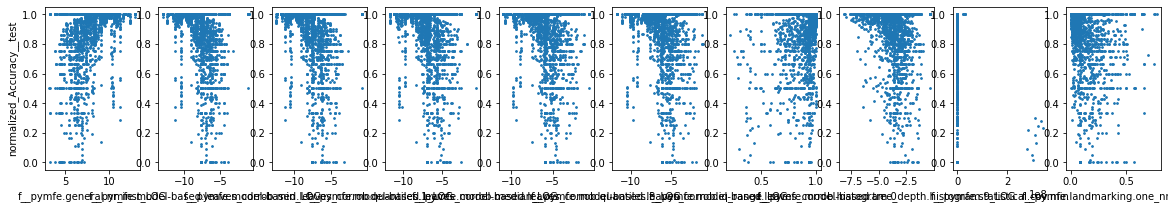

In [721]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


### ResNet

In [722]:
alg = "rtdl_ResNet"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.38
failures: 170
successes: 1525


In [723]:
from sklearn import tree

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves).fit(x, y)

In [724]:
clf_display.classes_

array([0, 1])

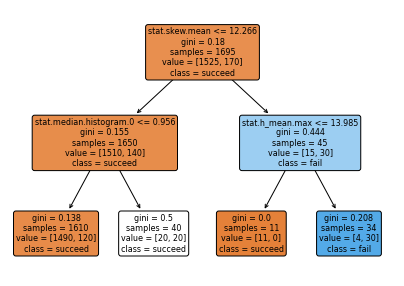

accuracy of this classifier: 0.9150442477876106
base rate: 0.8997050147492626


In [725]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.statistical.can_cor.max : 0.3364783697386568 (p=3.85e-46)
f__pymfe.statistical.roy_root_LOG : 0.3280351628427773 (p=8.23e-44)
f__pymfe.statistical.lh_trace_LOG : 0.3221914346510762 (p=3.06e-42)
f__pymfe.statistical.can_cor.quantiles.3 : 0.314809529425119 (p=2.62e-40)
f__pymfe.statistical.w_lambda : -0.3051162643339329 (p=7.52e-38)
f__pymfe.landmarking.linear_discr.quantiles.1 : 0.30476874897031847 (p=9.18e-38)
f__pymfe.landmarking.linear_discr.median : 0.3018129870583982 (p=4.93e-37)
f__pymfe.landmarking.linear_discr.mean : 0.29987160112579264 (p=1.47e-36)
f__pymfe.landmarking.linear_discr.min : 0.29714641983636003 (p=6.73e-36)
f__pymfe.statistical.p_trace_LOG : 0.2969574352775775 (p=7.48e-36)
f__pymfe.statistical.can_cor.mean : 0.2959908520024941 (p=1.28e-35)
f__pymfe.landmarking.linear_discr.quantiles.3 : 0.28904919712659116 (p=5.61e-34)
f__pymfe.statistical.can_cor.median : 0.2887921647753167 (p=6.44e-34)
f__pymfe.statistical.can

Text(0, 0.5, 'normalized_Accuracy__test')

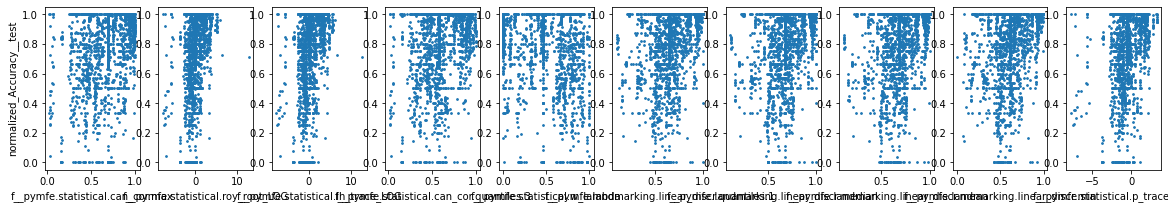

In [726]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)

### SAINT

In [727]:
alg = "SAINT"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.26
failures: 106
successes: 949


In [728]:
from sklearn import tree

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves).fit(x, y)

In [729]:
clf_display.classes_

array([0, 1])

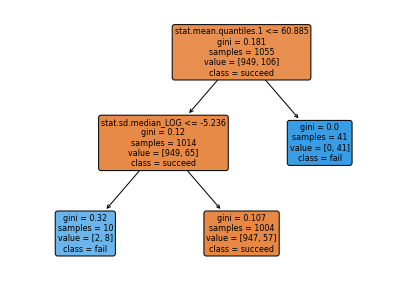

accuracy of this classifier: 0.9440758293838862
base rate: 0.8995260663507109


In [730]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()

print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")

/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.statistical.can_cor.max : 0.3312943127085179 (p=1.92e-28)
f__pymfe.statistical.w_lambda : -0.302504732248729 (p=9.16e-24)
f__pymfe.statistical.mean.median : -0.29579752134636933 (p=9.53e-23)
f__pymfe.statistical.mean.quantiles.1 : -0.29443404710821225 (p=1.52e-22)
f__pymfe.statistical.mean.min : -0.29046759982475 (p=5.87e-22)
f__pymfe.statistical.can_cor.max_LOG : 0.27863010312547126 (p=2.90e-20)
f__pymfe.statistical.t_mean.median : -0.27619831317724874 (p=6.31e-20)
f__pymfe.statistical.max.median : -0.27420835444779396 (p=1.19e-19)
f__pymfe.statistical.p_trace_LOG : 0.2575197011441814 (p=1.92e-17)
f__pymfe.statistical.roy_root_LOG : 0.25588595607398584 (p=3.11e-17)
f__pymfe.landmarking.best_node.histogram.5.relative_LOG : -0.2554006829317656 (p=3.58e-17)
f__pymfe.statistical.can_cor.quantiles.3 : 0.2542331442461562 (p=5.03e-17)
f__pymfe.statistical.lh_trace_LOG : 0.24868060631092495 (p=2.47e-16)
f__pymfe.landmarking.best_node.histo

Text(0, 0.5, 'normalized_Accuracy__test')

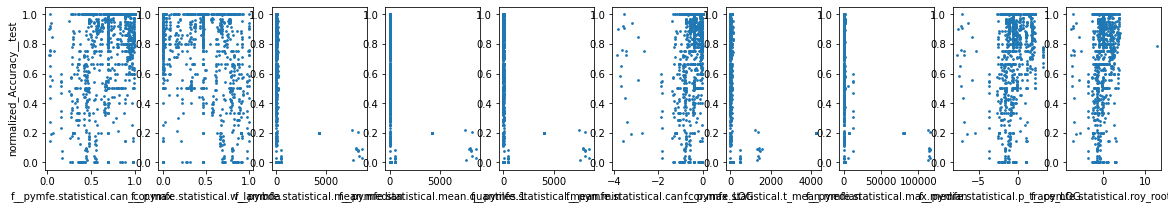

In [731]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


### DecisionTree

In [732]:
alg = "DecisionTree"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.00
failures: 197
successes: 1508


In [733]:
from sklearn import tree

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves, random_state=0).fit(x, y)

In [734]:
clf_display.classes_

array([0, 1])

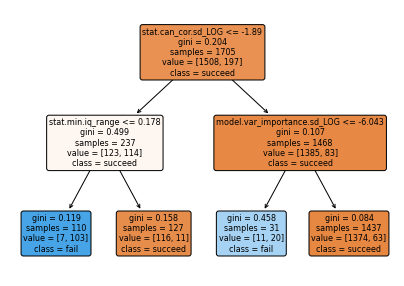

accuracy of this classifier: 0.9460410557184751
base rate: 0.8844574780058652


In [735]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()
print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.model-based.var_importance.sd_LOG : 0.4071136538975436 (p=4.60e-69)
f__pymfe.model-based.var_importance.max_LOG : 0.4054325262690874 (p=1.86e-68)
f__pymfe.model-based.nodes_repeated.count_LOG : -0.3564287290626893 (p=3.08e-52)
f__pymfe.model-based.var_importance.mean_LOG : 0.3497438522043523 (p=3.10e-50)
f__pymfe.statistical.eigenvalues.histogram.9_LOG : 0.34478207438730796 (p=8.84e-49)
f__pymfe.general.nr_attr_LOG : -0.3304749897378048 (p=9.94e-45)
f__pymfe.model-based.var_importance.max : 0.3234118801653333 (p=8.30e-43)
f__pymfe.statistical.var.histogram.2 : -0.3174523704177597 (p=3.17e-41)
f__pymfe.general.freq_class.max_LOG : 0.3157097140676313 (p=9.05e-41)
f__pymfe.model-based.leaves_per_class.max_LOG : 0.31324695653352325 (p=3.94e-40)
f__pymfe.model-based.leaves_per_class.max : 0.3101641805561487 (p=2.44e-39)
f__pymfe.model-based.var_importance.sd : 0.30897802876634034 (p=4.89e-39)
f__pymfe.statistical.range.histogram.0 : 0.30

Text(0, 0.5, 'normalized_Accuracy__test')

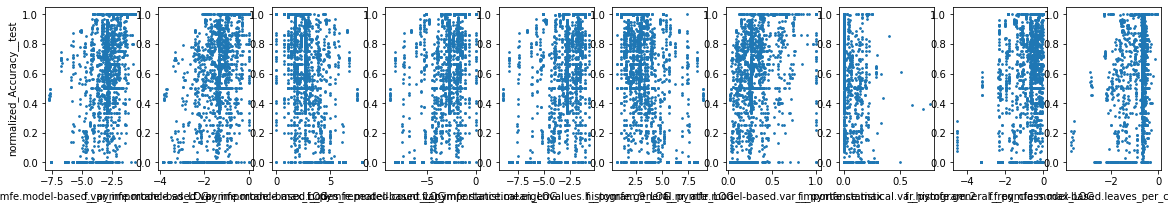

In [736]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


### NODE

In [737]:
alg = "NODE"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.33
failures: 141
successes: 1234


In [738]:
from sklearn import tree

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves, random_state=0).fit(x, y)

In [739]:
clf_display.classes_

array([0, 1])

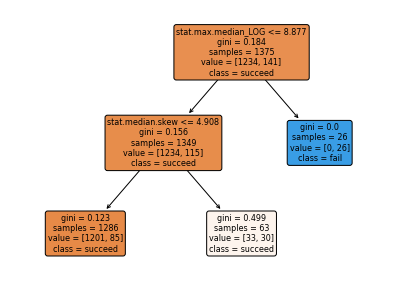

accuracy of this classifier: 0.9163636363636364
base rate: 0.8974545454545455


In [740]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()
print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.landmarking.naive_bayes.quantiles.1 : 0.3166504007387355 (p=2.13e-33)
f__pymfe.landmarking.naive_bayes.mean : 0.3097522533446972 (p=5.84e-32)
f__pymfe.landmarking.naive_bayes.median : 0.3095511281520933 (p=6.42e-32)
f__pymfe.landmarking.naive_bayes.quantiles.1_LOG : 0.30318175644529644 (p=1.26e-30)
f__pymfe.landmarking.naive_bayes.median_LOG : 0.2982038431781202 (p=1.23e-29)
f__pymfe.landmarking.naive_bayes.mean_LOG : 0.29626546988185953 (p=2.94e-29)
f__pymfe.landmarking.naive_bayes.quantiles.3 : 0.2914164053264839 (p=2.54e-28)
f__pymfe.landmarking.linear_discr.quantiles.1 : 0.2863463470185486 (p=2.32e-27)
f__pymfe.landmarking.linear_discr.mean : 0.28487656409628737 (p=4.37e-27)
f__pymfe.landmarking.linear_discr.median : 0.2828008612508238 (p=1.06e-26)
f__pymfe.landmarking.naive_bayes.quantiles.3_LOG : 0.28163381332890225 (p=1.74e-26)
f__pymfe.landmarking.naive_bayes.min : 0.2747958539909234 (p=3.03e-25)
f__pymfe.statistical.skewnes

Text(0, 0.5, 'normalized_Accuracy__test')

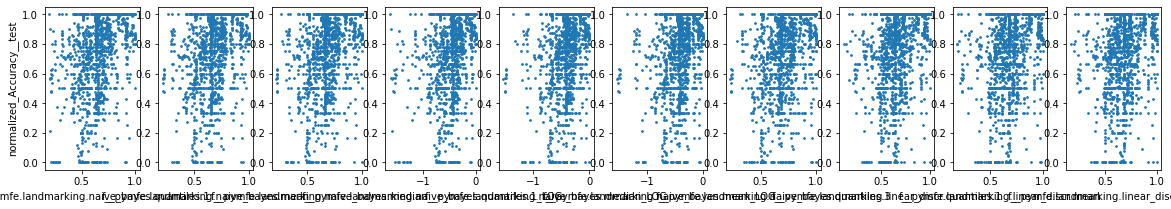

In [741]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


### RandomForest

In [742]:
alg = "RandomForest"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.42
failures: 170
successes: 1525


In [743]:
from sklearn import tree

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves, random_state=0).fit(x, y)

In [744]:
clf_display.classes_

array([0, 1])

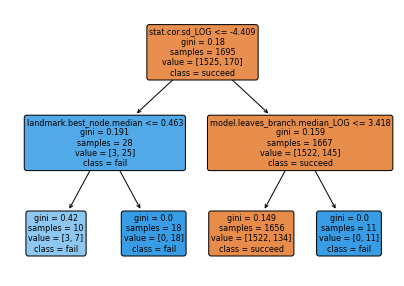

accuracy of this classifier: 0.9191740412979351
base rate: 0.8997050147492626


In [745]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()
print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.model-based.leaves_branch.quantiles.3 : -0.23092725070555895 (p=5.93e-22)
f__pymfe.model-based.tree_depth.median : -0.23050189495259954 (p=7.08e-22)
f__pymfe.model-based.tree_shape.quantiles.1_LOG : 0.23031804031515177 (p=7.64e-22)
f__pymfe.model-based.leaves_branch.mean : -0.23001861659215672 (p=8.65e-22)
f__pymfe.model-based.leaves_branch.median : -0.22839693058572677 (p=1.69e-21)
f__pymfe.model-based.tree_shape.median_LOG : 0.2281362379284045 (p=1.88e-21)
f__pymfe.model-based.leaves_branch.iq_range : -0.225383846009827 (p=5.81e-21)
f__pymfe.model-based.leaves_homo.median_LOG : -0.22383426894404335 (p=1.09e-20)
f__pymfe.model-based.leaves_homo.max_LOG : -0.22168428799084383 (p=2.58e-20)
f__pymfe.model-based.leaves_branch.sd : -0.22167913733270125 (p=2.58e-20)
f__pymfe.model-based.leaves_branch.max : -0.22143670112776112 (p=2.84e-20)
f__pymfe.model-based.tree_shape.min_LOG : 0.2212611002721143 (p=3.05e-20)
f__pymfe.model-based.leav

Text(0, 0.5, 'normalized_Accuracy__test')

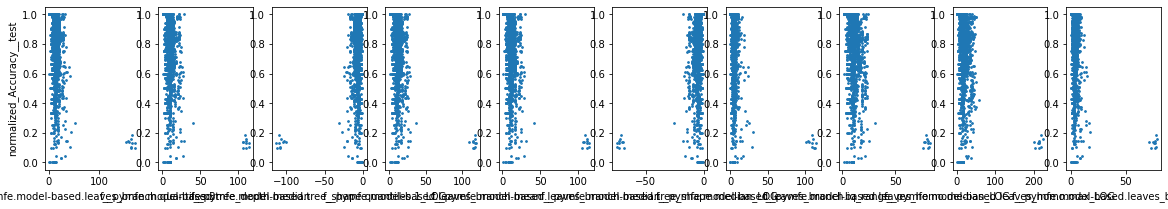

In [746]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


### FTTransformer

In [747]:
alg = "rtdl_FTTransformer"
alg_q = alg_quantiles[alg]
# first find the 20th percentile of all normalized metrics for this alg
df_alg = df.loc[df["alg_name"] == alg, :].copy()

df_alg.loc[:, "failure"] = (df_alg[metric_col] <= alg_q).astype(int)

print(f"normalized accuracy quantile: {alg_q:.2f}")
print(f"failures: {sum(df_alg[metric_col] <= alg_q)}")
print(f"successes: {sum(df_alg[metric_col] > alg_q)}")

normalized accuracy quantile: 0.29
failures: 139
successes: 1246


In [748]:
from sklearn import tree

x = df_alg[all_feature_cols].values.clip(-1e10, 1e10)
y = df_alg["failure"]

# train a single tree of max-depth 5 to visualize
clf_display = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_num_leaves, random_state=0).fit(x, y)

In [749]:
clf_display.classes_

array([0, 1])

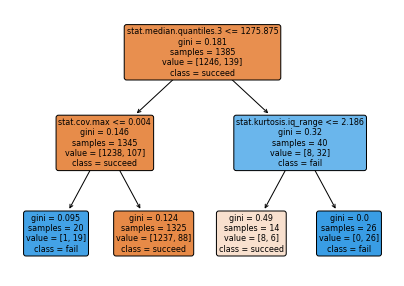

accuracy of this classifier: 0.9314079422382672
base rate: 0.8996389891696751


In [750]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1,figsize=figsize)

annotations = tree.plot_tree(
    clf_display, 
    # max_depth=5, 
    feature_names=nice_feature_names, 
    class_names=["succeed", "fail"],
    filled=True, 
    ax=ax,
    fontsize=8,
    rounded=True,
)
# print(tree.export_text(clf_display, feature_names=feature_cols))
plt.show()
print(f"accuracy of this classifier: {metrics.accuracy_score(y, clf_display.predict(x))}")
frac_fail = sum(df_alg[metric_col] <= alg_q) / float(len(df_alg))
print(f"base rate: {max(frac_fail, 1. - frac_fail)}")


/Users/duncan/miniconda3/envs/sklearn/lib/python3.10/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.


most correlated features with norm. accuracy
f__pymfe.landmarking.naive_bayes.quantiles.1 : 0.3156131121652912 (p=2.08e-33)
f__pymfe.landmarking.naive_bayes.mean : 0.30933215694124033 (p=4.29e-32)
f__pymfe.landmarking.naive_bayes.median : 0.3052944106774079 (p=2.89e-31)
f__pymfe.landmarking.naive_bayes.min : 0.30471760736887127 (p=3.79e-31)
f__pymfe.landmarking.naive_bayes.quantiles.1_LOG : 0.3032693975973015 (p=7.45e-31)
f__pymfe.landmarking.naive_bayes.mean_LOG : 0.29620777917027835 (p=1.90e-29)
f__pymfe.landmarking.naive_bayes.median_LOG : 0.2950593596488076 (p=3.19e-29)
f__pymfe.landmarking.linear_discr.quantiles.1 : 0.2921604716530455 (p=1.17e-28)
f__pymfe.landmarking.naive_bayes.quantiles.3 : 0.290097268298618 (p=2.92e-28)
f__pymfe.landmarking.linear_discr.median : 0.28947872404825686 (p=3.83e-28)
f__pymfe.landmarking.linear_discr.mean : 0.2862196387598695 (p=1.59e-27)
f__pymfe.landmarking.linear_discr.quantiles.1_LOG : 0.2828985100138119 (p=6.69e-27)
f__pymfe.landmarking.naive_b

Text(0, 0.5, 'normalized_Accuracy__test')

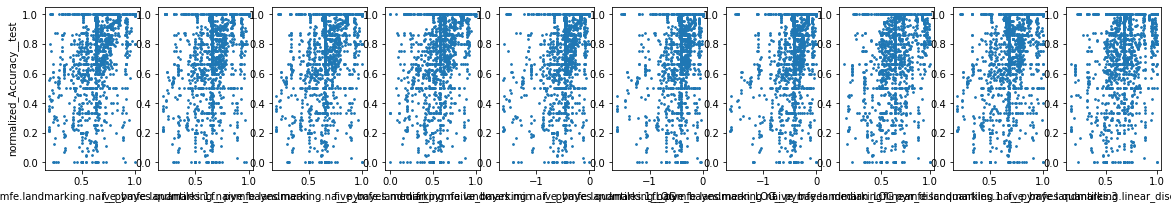

In [751]:
# find features correlated with performance
cor_list = []
p_list = []
metric_col = "normalized_Accuracy__test"
for f in all_feature_cols_with_log:
    c, p = corr(df_alg[f], df_alg[metric_col])
    cor_list.append(c)
    p_list.append(p)

idx_sorted = (-np.abs(cor_list)).argsort()

print("most correlated features with norm. accuracy")
for i in range(20):
    print(f"{all_feature_cols_with_log[idx_sorted[i]]:20s} : {cor_list[idx_sorted[i]]} (p={p_list[idx_sorted[i]]:.2e})")

# plot performance with certain features

fig, axs = plt.subplots(1, 10, figsize=(20, 3))

for i in range(10):
    plot_feat = all_feature_cols_with_log[idx_sorted[i]]
    feat_name = plot_feat
    # feat_name = nice_feature_names[idx_sorted_q1a[i]]

    axs[i].scatter(df_alg[plot_feat], df_alg[metric_col], s=3)
    # axs[i].scatter(df_q1[plot_feat], df_q1["neural_tree_diff"], s=3)

    axs[i].set_xlabel(feat_name)
    # ax.legend()
    # ax.set_xlabel(feat_comparison[0])
    # ax.set_ylabel(feat_comparison[1])

    # ax.set_yscale("log")
    # axs[i].set_xscale("log")

axs[0].set_ylabel(metric_col)


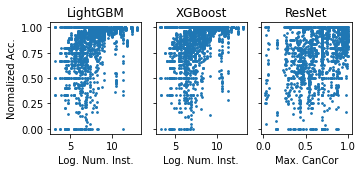

In [773]:
# make some curated plots...


alg_1 = "LightGBM"
feat_1 = "f__pymfe.general.nr_inst_LOG"
alg_2 = "XGBoost"
feat_2 = "f__pymfe.general.nr_inst_LOG"
alg_3 = "rtdl_ResNet"
feat_3 = "f__pymfe.statistical.can_cor.max"

# plot performance with certain features

fig, axs = plt.subplots(1, 3, figsize=(5, 2.5), sharey=True)


axs[0].scatter(df[df["alg_name"] == alg_1][feat_1], df[df["alg_name"] == alg_1][metric_col], s=3)
axs[0].set_xlabel("Log. Num. Inst.")
axs[0].set_title(alg_1)

axs[1].scatter(df[df["alg_name"] == alg_2][feat_2], df[df["alg_name"] == alg_2][metric_col], s=3)
axs[1].set_xlabel("Log. Num. Inst.")
axs[1].set_title(alg_2)

axs[2].scatter(df[df["alg_name"] == alg_3][feat_3], df[df["alg_name"] == alg_3][metric_col], s=3)
axs[2].set_xlabel("Max. CanCor")
axs[2].set_title("ResNet")


axs[0].set_ylabel("Normalized Acc.")

plt.tight_layout()
plt.savefig("corr_with_performance.pdf", bbox_inches="tight")
